In [1]:
# Imports
import json
import os

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import pairwise_distances
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.model_selection import cross_val_score, StratifiedKFold
from sklearn.pipeline import make_pipeline
from sklearn.tree import DecisionTreeClassifier, export_text
from sklearn.inspection import PartialDependenceDisplay
from sklearn.compose import ColumnTransformer
from sklearn.cluster import KMeans
from sklearn.manifold import TSNE
from scipy.stats import ttest_rel, wilcoxon, pearsonr, spearmanr, ks_2samp

In [2]:
def df_gen(RESULTS_DIR, NSHARDS = 10):  
  dfs = []
  for shard_idx in range(NSHARDS):
    filename = 'results.ndjson-%s-of-%s' % (str(shard_idx).zfill(5), str(NSHARDS).zfill(5))
    print(filename)

    with open(f'{RESULTS_DIR}/{filename}', 'r') as f:
      lines = f.readlines()
      records = map(json.loads, lines)
      dfs.append(pd.DataFrame.from_records(records))

  # Construct df and remove nans
  results_df = pd.concat(dfs)
  results_df.drop(['marginal_param', 'fixed_params'], axis=1, inplace=True)
  # results_df.dropna(axis=0, inplace=True)
  del dfs
  return results_df

In [5]:
def plot_model_perf_vs_feature_noise_dim(dfs, models, metric, noise_feature_dims):
    plot_data = []
    for i, df in enumerate(dfs):
        # Select the metric columns for the models
        df_copy = df[[f'{model}__{metric}' for model in models]].copy()
        # Add the feature dimension column
        df_copy['feature_dim'] = noise_feature_dims[i]
        plot_data.append(df_copy)

    combined_df_wide = pd.concat(plot_data, ignore_index=True)


    # --- 3. Reshape Data from Wide to Long Format ---
    # This is the key step. We use `pd.melt` to turn the model columns
    # into rows, making the data suitable for seaborn's `hue` parameter.

    id_vars = ['feature_dim']
    value_vars = [f'{model}__{metric}' for model in models]

    combined_df_long = pd.melt(
        combined_df_wide,
        id_vars=id_vars,
        value_vars=value_vars,
        var_name='model_metric', # New column for the original column names
        value_name='performance_score' # New column for the performance values
    )

    # Clean up the model names (e.g., 'GCN__test_rocauc_ovr' -> 'GCN')
    combined_df_long['model'] = combined_df_long['model_metric'].str.replace(f'__{metric}', '', regex=False)


    # --- 4. Create the Combined Boxplot ---
    # Now we create a single plot, using `hue` to differentiate the models.

    plt.style.use('seaborn-v0_8-whitegrid')
    fig, ax = plt.subplots(figsize=(12, 8))

    sns.boxplot(
        x='feature_dim',
        y='performance_score',
        hue='model', # This tells seaborn to use different colors for each model
        data=combined_df_long,
        ax=ax,
        palette='muted' # A nice color palette
    )

    # --- 5. Customize and Show the Plot ---
    ax.set_title(f'Model Performance ({metric}) vs. Noise Feature Dimension', fontsize=16, fontweight='bold')
    ax.set_xlabel('Number of Noise Features', fontsize=12)
    ax.set_ylabel('Performance Score (ROC AUC)', fontsize=12)
    ax.legend(title='Model') # Add a legend to identify the colors

    plt.tight_layout()
    plt.show()

In [9]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/1'
df = df_gen(RESULTS_DIR = RESULTS_DIR) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


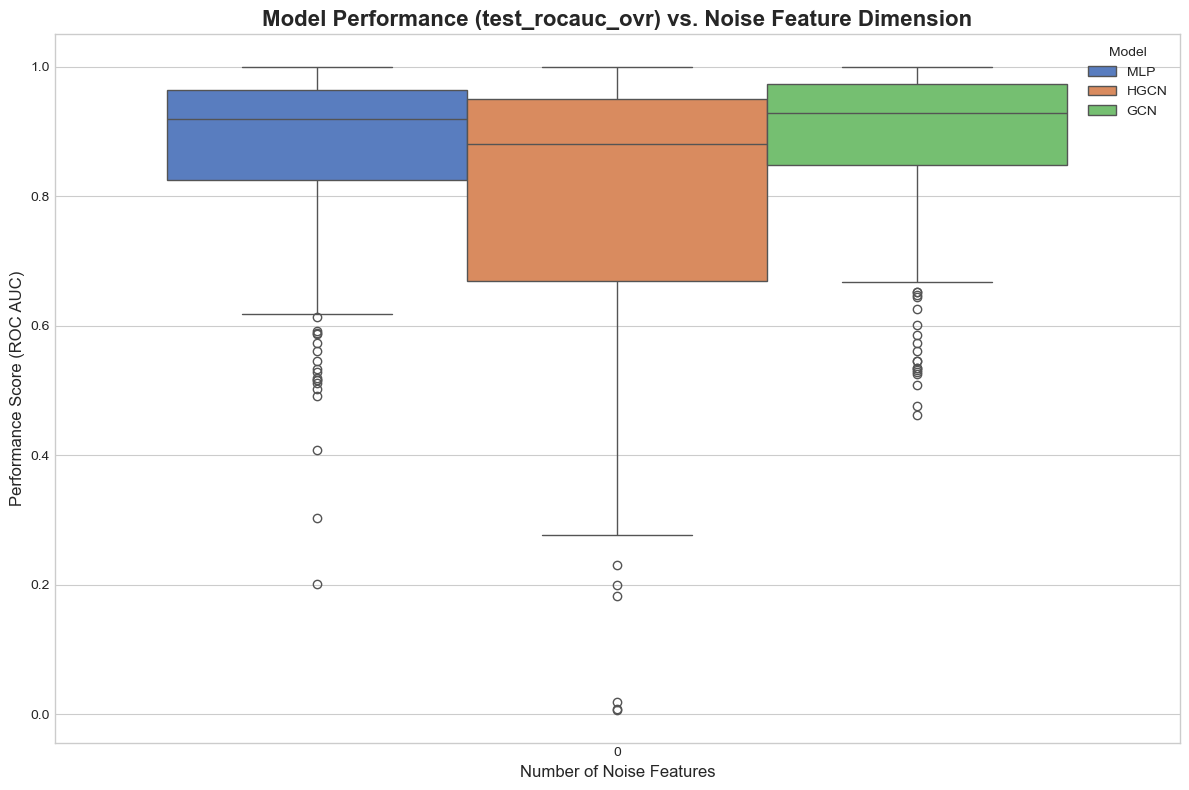

In [10]:
plot_model_perf_vs_feature_noise_dim([df], models = ['MLP', 'HGCN', 'GCN'], metric = 'test_rocauc_ovr', noise_feature_dims=[0])

In [15]:
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/'
df75 = df_gen(RESULTS_DIR + '/0.75var')
df5 = df_gen(RESULTS_DIR + '/0.5var')
df2 = df_gen(RESULTS_DIR + '/0.2var')

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


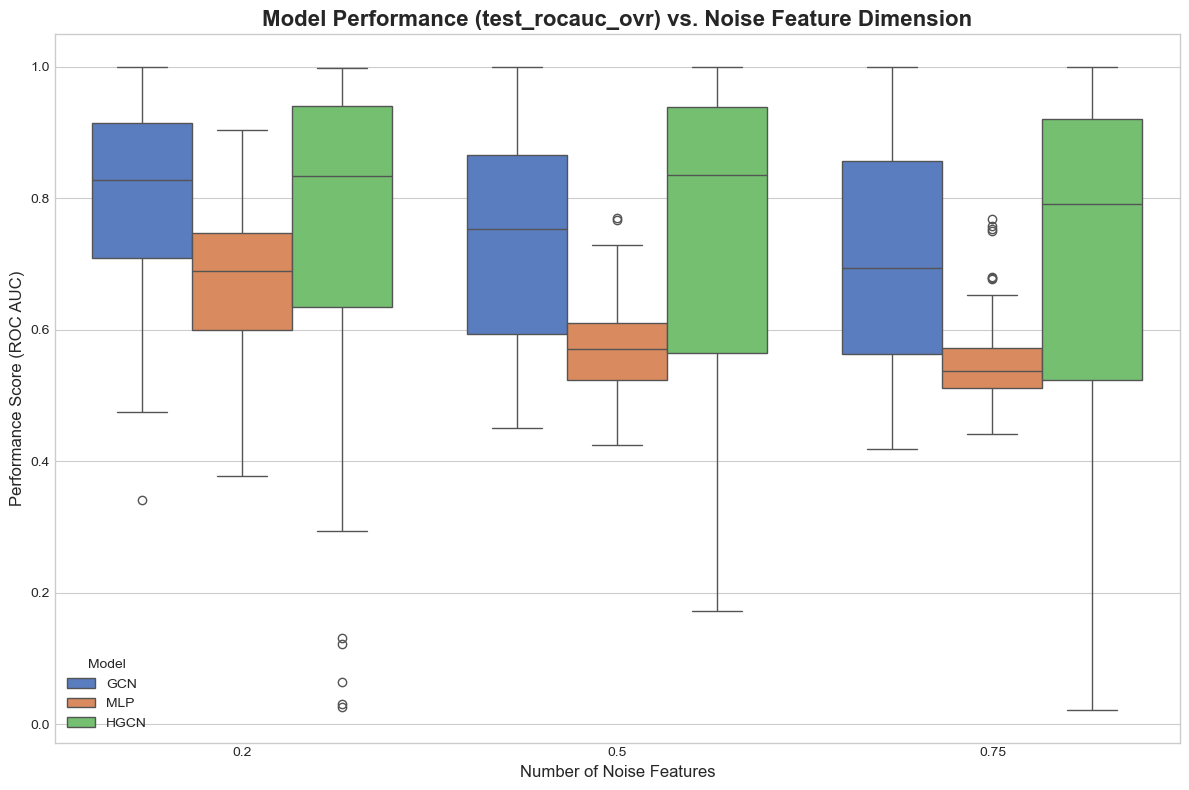

In [16]:
plot_model_perf_vs_feature_noise_dim(dfs = [df75, df5, df2], metric=metric, models = models, noise_feature_dims = [.75, .5, .2])

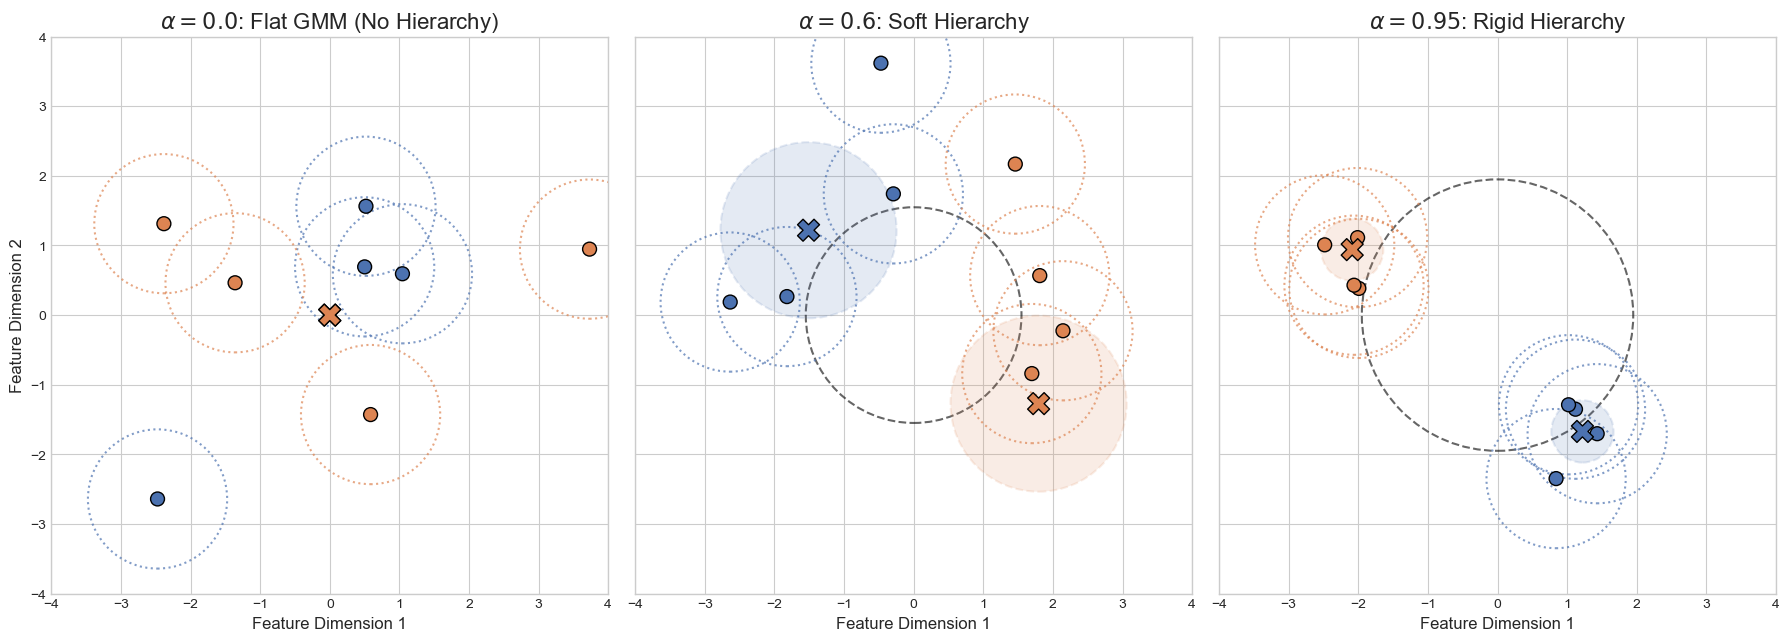

In [48]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from matplotlib.patches import Circle

# --- Parameters for the visualization ---
K = 8  # Total number of classes (sub-clusters)
G = 2  # Number of super-clusters
D = 2  # Feature dimension (we use 2D for plotting)
d_squared = 4.0  # Base distance (variance of centers)
node_noise_variance = 1.0 # The variance for the final node features

# Assign classes to super-groups and set colors
class_to_super = np.array([i // (K // G) for i in range(K)])
colors = sns.color_palette('deep', G)
class_colors = [colors[g] for g in class_to_super]

def generate_hierarchical_centroids(alpha, K, G, D, d_squared, class_to_super):
    """
    Generates class centroids based on the hierarchical model.
    Returns both class means and the super means used to create them.
    """
    tau_top_var = alpha * d_squared
    tau_class_var = (1 - alpha) * d_squared
    
    # Using a fixed seed here just for this specific visualization's consistency
    mu_top = np.random.multivariate_normal(
        mean=np.zeros(D), cov=np.identity(D) * tau_top_var, size=G)
    
    mu_class = np.zeros((K, D))
    for k in range(K):
        parent_super_mean = mu_top[class_to_super[k]]
        mu_class[k, :] = np.random.multivariate_normal(
            mean=parent_super_mean, cov=np.identity(D) * tau_class_var)
        
    return mu_class, mu_top

# --- Create the plot ---
sns.set_style("whitegrid")
fig, axes = plt.subplots(1, 3, figsize=(18, 6), sharex=True, sharey=True)
alphas_to_plot = [0.0, 0.6, 0.95]
titles = [
    r'$\alpha = 0.0$: Flat GMM (No Hierarchy)',
    r'$\alpha = 0.6$: Soft Hierarchy',
    r'$\alpha = 0.95$: Rigid Hierarchy'
]

for i, alpha in enumerate(alphas_to_plot):
    ax = axes[i]
    
    centroids, mu_top = generate_hierarchical_centroids(
        alpha, K, G, D, d_squared, class_to_super
    )
    
    # Draw reference circle for super-group sampling
    tau_top_std = np.sqrt(alpha * d_squared)
    origin_circle = Circle((0, 0), tau_top_std, color='k', linestyle='--', fill=False, lw=1.5, alpha=0.6)
    ax.add_patch(origin_circle)

    # Draw reference circles for sub-group sampling
    if alpha > 0:
        tau_class_std = np.sqrt((1.0 - alpha) * d_squared)
        for g in range(G):
            super_mean_circle = Circle(mu_top[g], tau_class_std, color=colors[g], linestyle='--', 
                                       fill=True, lw=1.5, alpha=0.15)
            ax.add_patch(super_mean_circle)

    # --- ADDED: Draw circles of unit variance around each sub-cluster center ---
    node_noise_std = np.sqrt(node_noise_variance)
    for k in range(K):
        center = centroids[k]
        # Use a fine dotted line for this final level of variance
        node_noise_circle = Circle(center, node_noise_std, edgecolor=class_colors[k], 
                                   linestyle=':', fill=False, lw=1.5, alpha=0.7)
        ax.add_patch(node_noise_circle)

    # Plot the class centroids (dots) and super-group means (X's)
    ax.scatter(centroids[:, 0], centroids[:, 1], c=class_colors, s=100, alpha=1.0, edgecolors='k', zorder=10)
    ax.scatter(mu_top[:, 0], mu_top[:, 1], c=colors, s=250, marker='X', edgecolors='k', zorder=10)

    ax.set_title(titles[i], fontsize=16)
    ax.set_aspect('equal', adjustable='box')
    ax.set_xlabel('Feature Dimension 1', fontsize=12)
    ax.set_ylabel('Feature Dimension 2' if i == 0 else '', fontsize=12)
    ax.set_xlim(-4, 4)
    ax.set_ylim(-4, 4)

# fig.suptitle('Visualisation of Class Centroid Geometry as Hierarchy Parameter $\\alpha$ Varies', fontsize=18, y=1.05)
plt.tight_layout()
plt.savefig('hierarchical_feature_space_full_variance.png', dpi=300, bbox_inches='tight')
plt.show()

In [83]:
# now generated with signal noise variance of .25
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/gen_params_varied/rq2'
dfs = []
for i in range(1,5):
    df = df_gen(RESULTS_DIR + f'/{i}')
    dfs.append(df)
df5 = df_gen(RESULTS_DIR + '/5/5')
dfs.append(df5)
df = pd.concat(dfs)
df = df.reset_index(drop=True) 

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.nd

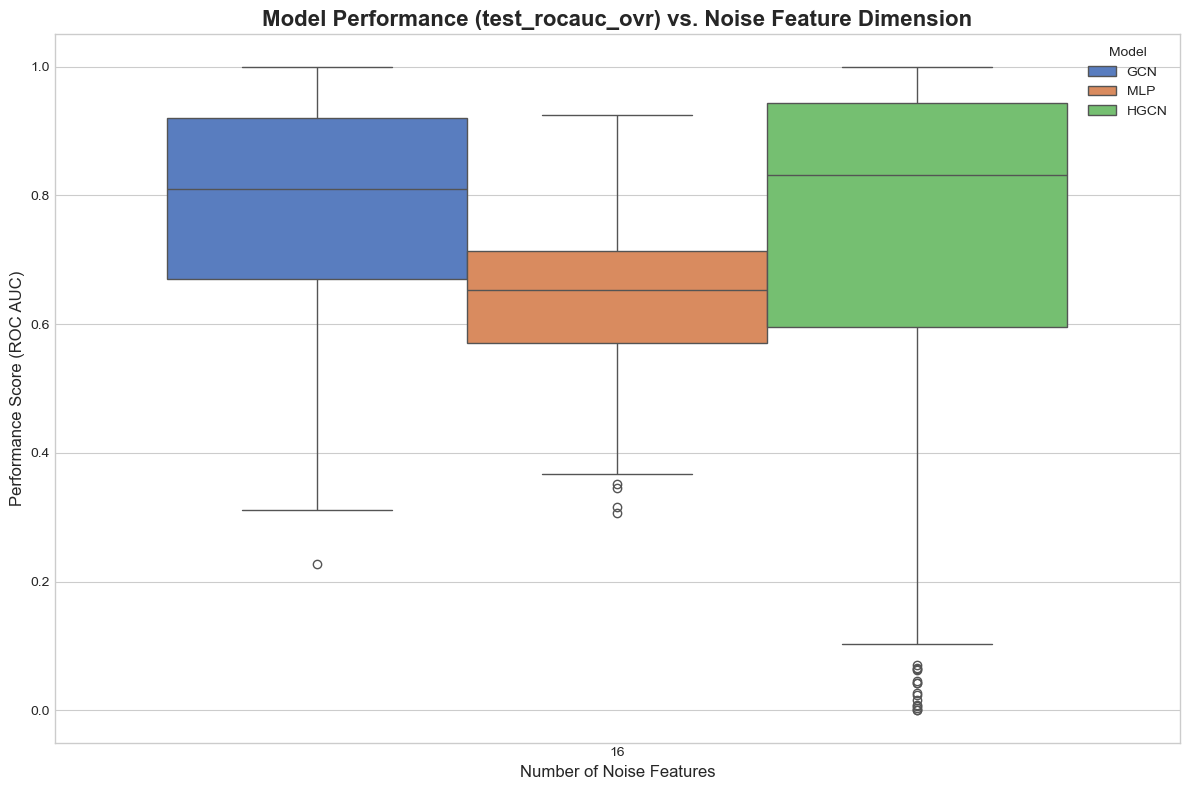

In [84]:
plot_model_perf_vs_feature_noise_dim([df], models, metric, noise_feature_dims=[16])

In [62]:
df[df['num_clusters'] == 8][graph_metrics_refined].describe()

,nvertex,avg_degree,degree_gini,p_to_q_ratio,num_clusters,community_size_simpsons,feature_center_distance,avg_cc,power_exponent,min_deg
count,295.000000,295.000000,295.000000,295.000000,295.0,295.000000,295.000000,295.000000,295.000000,295.000000
mean,2517.952542,14.949463,0.524298,8.675997,8.0,0.143725,0.962288,0.092158,1.640612,10.423729
std,860.391861,7.648235,0.101109,4.336788,0.0,0.009650,0.600605,0.074484,0.813178,5.204013
min,1026.000000,2.471256,0.337729,1.135035,8.0,0.125022,0.001966,0.001861,0.209948,2.000000
25%,1742.000000,7.986411,0.434085,5.142415,8.0,0.136240,0.435837,0.031511,0.950744,6.000000
50%,2532.000000,15.128873,0.520514,8.582148,8.0,0.145581,0.931724,0.073094,1.666601,11.000000
75%,3235.000000,21.004025,0.604974,12.537609,8.0,0.151797,1.514386,0.134337,2.390747,15.000000
max,4089.000000,31.693222,0.758348,15.955652,8.0,0.157240,1.993897,0.369299,2.995134,19.000000


In [31]:
def smoothed_plot_perf_vs_metric(
    df: pd.DataFrame,
    models: list[str],
    perf_meas: str,
    metric: str,
    n_bins: int = 10,
    figsize: tuple[int, int] = (8, 5),
    cmap: str = 'tab10'
):
    """
    Plot smoothed binned performance vs. metric for multiple models,
    with shaded 95% confidence intervals around the mean.

    Parameters
    ----------
    df : DataFrame
        Must contain the column [metric] and, for each model in `models`,
        a performance column named model+perf_meas (e.g. 'GCN'+'accuracy' → 'GCNaccuracy').
    models : list of str
        Model-name prefixes.
    perf_meas : str
        Performance-measure suffix (e.g. 'f1_macro', 'accuracy').
    metric : str
        The continuous metric to bin (e.g. 'homophily_rate').
    n_bins : int, default=10
        Number of equal-width bins to split the metric into.
    figsize : (width, height)
        Figure size.
    cmap : str
        Matplotlib colormap for the model curves.
    """
    # 1. Create equal-width bins and label them by their center values
    bin_edges = np.linspace(df[metric].min(), df[metric].max(), n_bins + 1)
    bin_centers = 0.5 * (bin_edges[:-1] + bin_edges[1:])
    df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)


    # 2. Initialize plot
    plt.figure(figsize=figsize)
    colors = plt.get_cmap(cmap)(np.linspace(0, 1, len(models)))

    # 3. For each model, compute mean and 95% CI in each bin and plot
    for model, color in zip(models, colors):
        col = f"{model}__{perf_meas}"
        if col not in df.columns:
            raise KeyError(f"Column '{col}' not found in DataFrame.")

        grp = df.groupby('_bin')[col]
        count = grp.count()                    # number of observations per bin
        mean = grp.mean()                      # mean performance per bin
        std  = grp.std(ddof=1)                 # sample standard deviation
        sem  = std / np.sqrt(count)            # standard error of the mean
        ci95 = 1.96 * sem                      

        # Only keep bins with data
        valid = count > 0
        x     = mean.index.astype(float)[valid]
        y     = mean[valid]
        lower = y - ci95[valid]
        upper = y + ci95[valid]

        # Plot mean line and shaded 95% CI
        plt.plot(x, y, label=model, color=color, linewidth=2)
        plt.fill_between(x, lower, upper, color=color, alpha=0.3)

    # 4. Final styling
    plt.xlabel(metric)
    plt.ylabel(perf_meas)
    plt.ylim(0,1)
    plt.title(f"{perf_meas} vs {metric} (binned, with 95% CI)")
    plt.legend(title="Model")
    plt.grid(True, linestyle='--', alpha=0.5)
    plt.tight_layout()
    plt.show()

    # Clean up temporary column
    df.drop(columns=['_bin'], inplace=True)

In [64]:
graph_metrics = ['nvertex', 'avg_degree', 'feature_center_distance',
       'p_to_q_ratio','num_clusters', 'cluster_size_slope', 'power_exponent', 'min_deg',
       'num_nodes', 'num_edges', 'edge_density',
       'degree_gini', 'coreness_eq_1',
       'coreness_geq_2', 'coreness_geq_5', 'coreness_geq_10', 'coreness_gini',
       'avg_cc', 'transitivity', 'num_triangles', 'cc_size',
       'power_law_estimate', 'edge_homogeneity',
       'avg_in_feature_angular_distance', 'avg_out_feature_angular_distance',
       'feature_angular_snr', 'pareto_exponent', 'avg_degree_est',
       'community_size_simpsons', 'p_to_q_ratio_est', 'p_to_q_ratio__est_dc']

graph_metrics_refined = ['nvertex', 'avg_degree', 'degree_gini', 'p_to_q_ratio',
              'community_size_simpsons', 'feature_center_distance',
                 'avg_cc', 'power_exponent', 'min_deg']

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grp = df.groupby('_bin')[col]
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version 

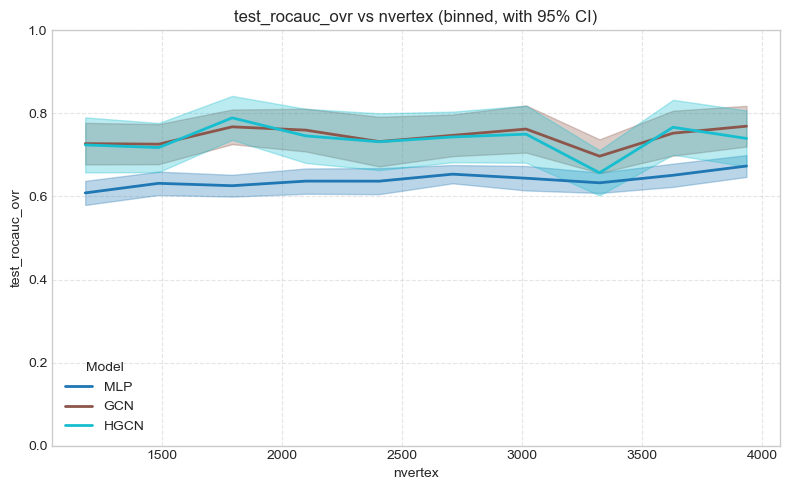

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

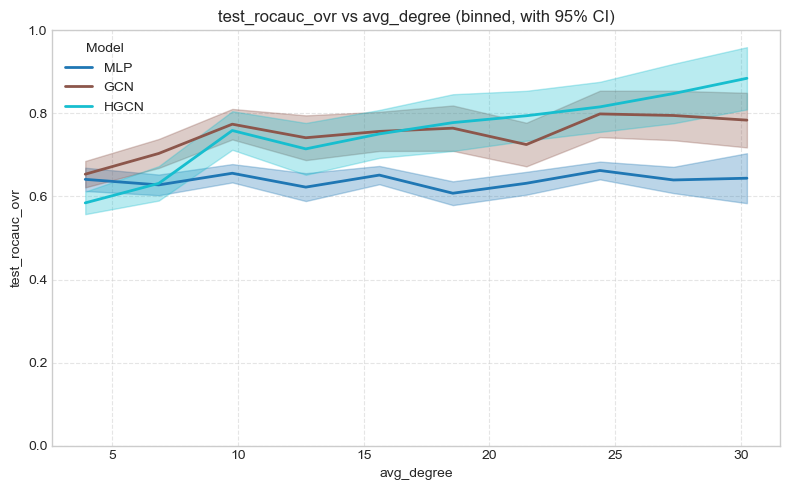

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

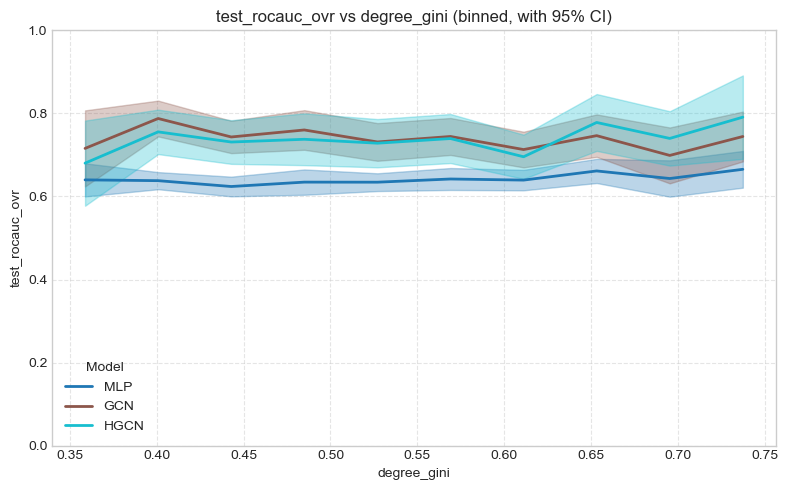

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

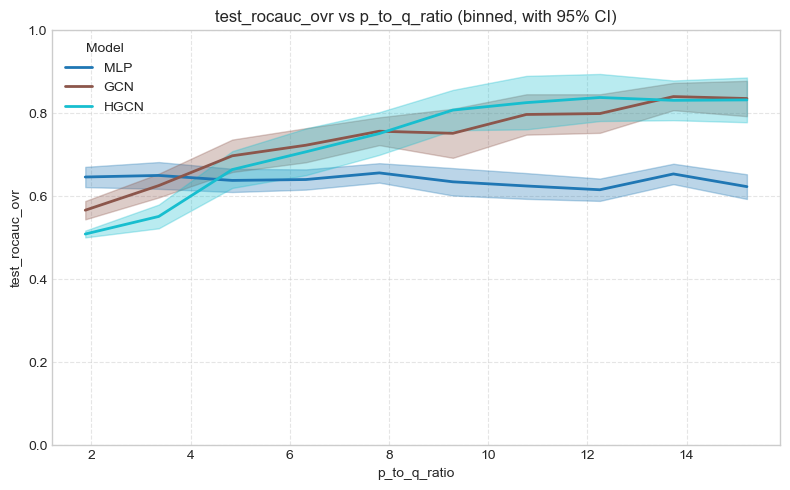

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

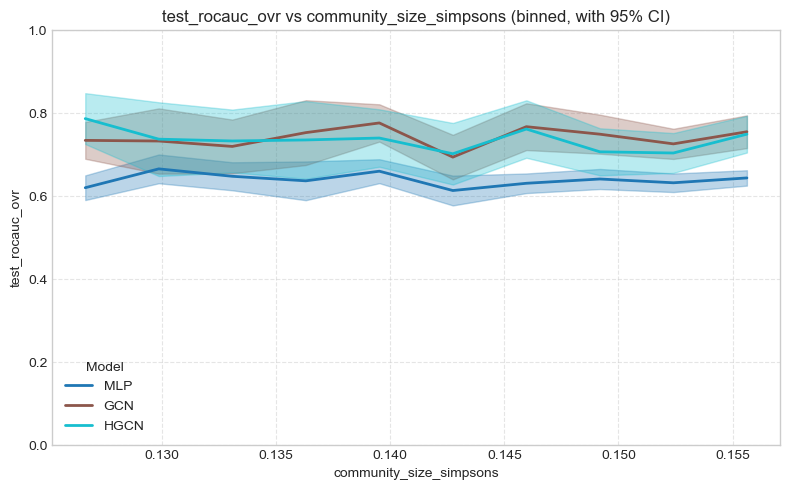

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

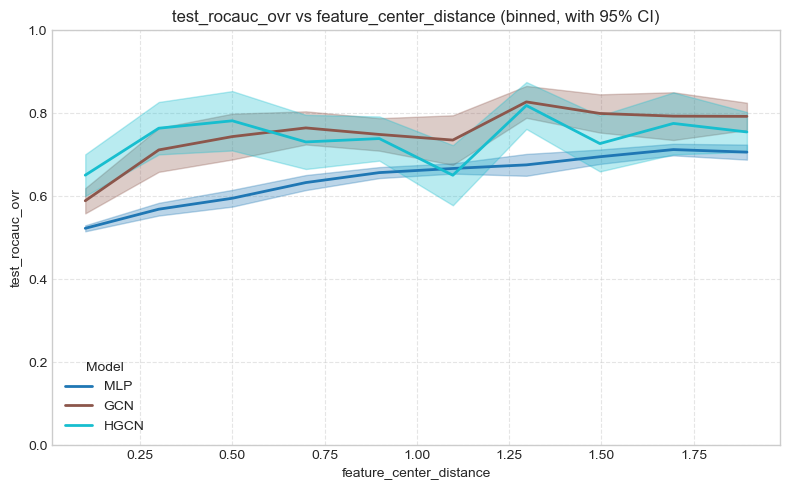

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

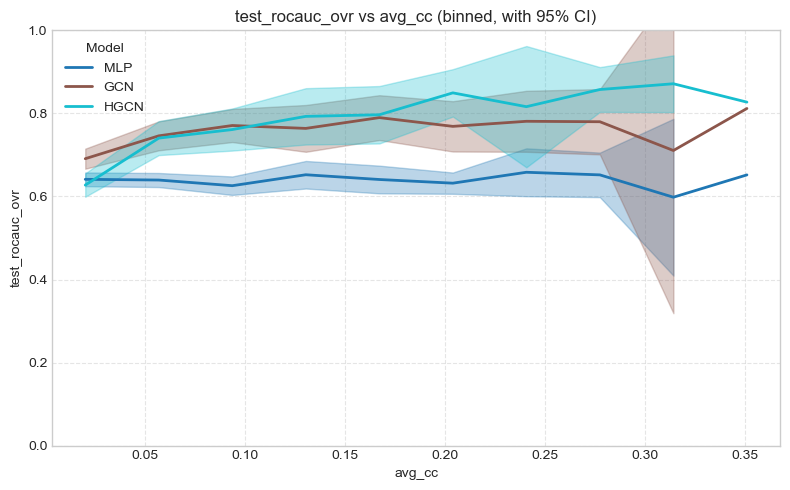

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

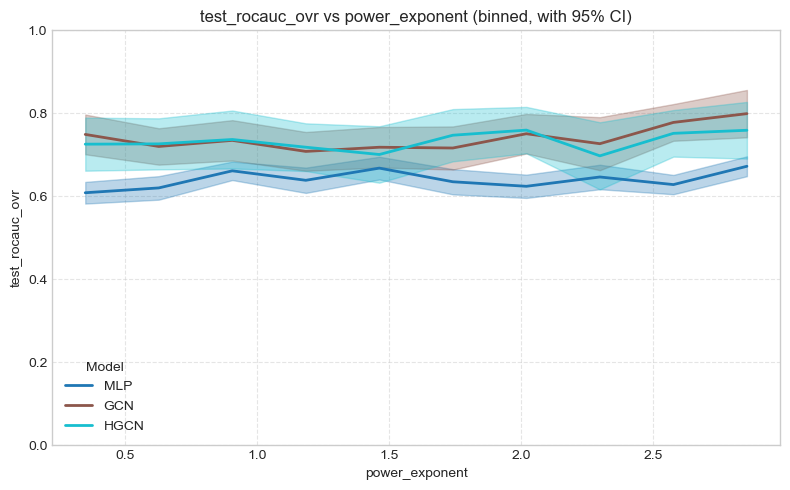

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:35: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df['_bin'] = pd.cut(df[metric], bins=bin_edges, include_lowest=True, labels=bin_centers)
/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:48: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future ver

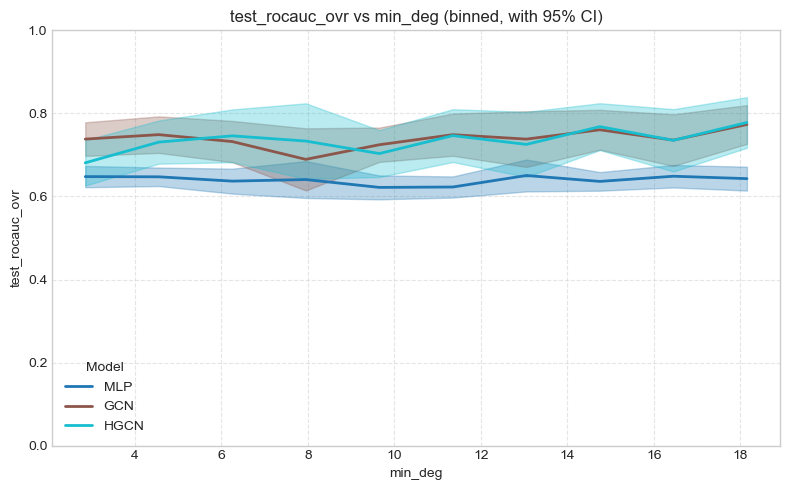

/var/folders/xx/jrs09g7x5nb0vzsph61j259c0000gn/T/ipykernel_67651/790685725.py:77: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.drop(columns=['_bin'], inplace=True)


In [65]:
for m in graph_metrics_refined:
    smoothed_plot_perf_vs_metric(df[df['num_clusters'] == 8], models = ['MLP', 'GCN', 'HGCN'], perf_meas= 'test_rocauc_ovr', metric = m)

## FLAT FEAT FLAT COMMUNITIES

In [85]:
## fixed parameter generation 
RESULTS_DIR = '../../graph_gen/snellius_gen/rq2/fixed_gen_params/flat_graph_flat_feat'
df1 = df_gen(RESULTS_DIR + '/1')
df2 = df_gen(RESULTS_DIR + '/2')
df = pd.concat([df1,df2])
df = df.reset_index(drop=True)
df

results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010
results.ndjson-00000-of-00010
results.ndjson-00001-of-00010
results.ndjson-00002-of-00010
results.ndjson-00003-of-00010
results.ndjson-00004-of-00010
results.ndjson-00005-of-00010
results.ndjson-00006-of-00010
results.ndjson-00007-of-00010
results.ndjson-00008-of-00010
results.ndjson-00009-of-00010


,nvertex,avg_degree,feature_center_distance,feature_dim,edge_center_distance,edge_feature_dim,p_to_q_ratio,num_clusters,cluster_size_slope,power_exponent,...,HGCN__model_c,HGCN__model_dropout,HGCN__model_hidden_channels,HGCN__model_in_channels,HGCN__model_lr,HGCN__model_num_layers,HGCN__model_weight_decay,HGCN__model_out_channels,HGCN__train_epochs,HGCN__train_patience
0,2000,9.358961,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.2,32,16,0.0020,1,0.0005,8,200,20
1,2000,9.684690,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.4,32,16,0.0005,2,0.0005,8,200,20
2,2000,8.924180,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.4,8,16,0.0005,2,0.0000,8,200,20
3,2000,9.455465,0.8,16,1.0,1,3.0,8,0.0,2.5,...,0.5,0.0,16,16,0.0010,2,0.0010,8,200,20
4,2000,9.454821,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.2,16,16,0.0020,2,0.0005,8,200,20
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
495,2000,9.812406,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.2,16,16,0.0020,2,0.0010,8,200,20
496,2000,9.496222,0.8,16,1.0,1,3.0,8,0.0,2.5,...,NaN,0.2,32,16,0.0005,2,0.0001,8,200,20
497,2000,8.950485,0.8,16,1.0,1,3.0,8,0.0,2.5,...,2.0,0.0,32,16,0.0005,2,0.0001,8,200,20
498,2000,9.780684,0.8,16,1.0,1,3.0,8,0.0,2.5,...,1.0,0.0,8,16,0.0020,2,0.0001,8,200,20


In [87]:
df[['edge_homogeneity', 'avg_degree']].describe()

,edge_homogeneity,avg_degree
count,500.000000,500.000000
mean,0.287285,9.453031
std,0.005084,0.233322
min,0.270983,8.486570
25%,0.283867,9.323551
50%,0.287625,9.478390
75%,0.290507,9.618871
max,0.304894,10.019105


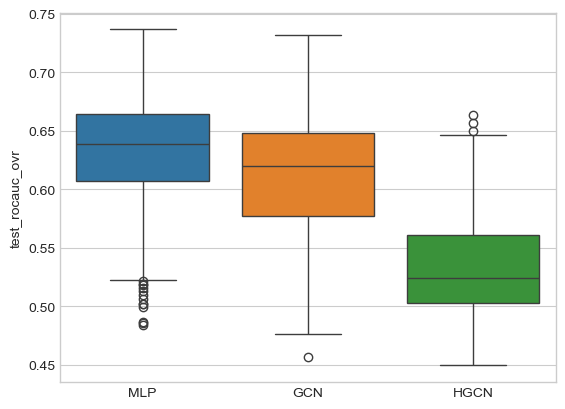

In [81]:
def boxplot_three_models(df, metric):
    models = ['MLP', 'GCN', 'HGCN']
    df_temp = df[[f'{model}__{metric}' for model in models]]
    df_temp = df_temp.rename(columns = {f'{model}__{metric}':model for model in models})
    sns.boxplot(df_temp
                )
    plt.ylabel(metric)
    plt.show()

boxplot_three_models(df, 'test_rocauc_ovr')